In [14]:
import numpy as np
import heapq as hq
import numba
import matplotlib.pyplot as plt

In [15]:
np.random.seed(0)
N = 12

c = 0.85
v = 1

mat_A = np.random.randint(2, size=(N, N))
mat_A = (mat_A + mat_A.T) -1

mat_A[mat_A<0] = 0

# compute the theoretical value of pagerank 
d = np.dot(mat_A, np.ones((N, 1)))
M = np.matmul(np.diagflat(1/d), mat_A)
q = np.zeros((N, 1))
q[v] = 1
p = np.dot(np.linalg.inv((np.eye(N)-c*M)/(1-c)), q).flatten()
p /= np.sum(p)

#print(p)

nzs = np.nonzero(np.triu(mat_A))
edgelist = [(a,b) for a,b in zip(nzs[0], nzs[1])]

In [16]:
edge_dict = {}
for edge in edgelist:
    if edge[0] in edge_dict:
        edge_dict[edge[0]].append(edge[1])
    else:
        edge_dict[edge[0]] = [edge[1]]
    if edge[0] != edge[1]:
        if edge[1] in edge_dict:
            edge_dict[edge[1]].append(edge[0])
        else:
            edge_dict[edge[1]] = [edge[0]]

In [17]:
N = max(edge_dict.keys())+1
A = [[]]*N
D = 0

for n in range(N):
    if n in edge_dict:
        A[n] = edge_dict[n]
        D += len(A[n])

In [18]:
# the function performs a push operation
def push(p, r, alpha, u, neighbours, neighbours_deg, th):
    
    # update the vectors (they are passed as pointers)
    delta = r[u]
    p[u] += (1-c)*delta
    r[u] = 0
    
    # initialize the indicator list that tells
    # approximate pagerank which node needs to be 
    # added into the priority queue for the next
    # iteration of the algorithm
    r_above_th = [False]*len(neighbours)
    
    # update r again and define the values 
    # of the indicator list
    for i, n in enumerate(neighbours):
        r[n] += c*delta/neighbours_deg[i]
        # a node v must be added if: r(v)/d(v) >= th
        if (neighbours_deg[i] == 0 and r[0] != 0) or r[n]/neighbours_deg[i] >= th:
            r_above_th[i] = True
            
    return r_above_th

In [19]:
def approximate_page_rank(A, N, D, v, c, epsilon):
    
    # initialize the approximate PageRank vectors
    p = np.zeros(N)
    r = np.zeros(N)
    r[v] = 1
    
    # for some reason pyhton decided to create a min pq
    # so we push the cost inverted (in this case d/1 = d)
    pq = []
    hq.heappush(pq, (len(A[v]), v))
    
    # precompute the inverse of epsilon for efficiency
    th = epsilon/D
    inv_th = D/epsilon
    
    # iterate over the heap as per defined in [1]
    while len(pq)>0 and pq[0][0] <= inv_th:
        u = hq.heappop(pq)[1]
        neigh = A[u]
        
        # compute the degrees of the neighbours
        neigh_deg = [0]*len(neigh)
        for i, n in enumerate(neigh):
            neigh_deg[i] = len(A[n])
        
        # call the push function to update p and r and
        # to get the list of neighbours to add to the pq
        r_above_th = push(p, r, c, u, neigh, neigh_deg, th)
        
        # push the new nodes accordingly to the indicator
        # vector r_above_th returned by push (boolean)
        for i, flag in enumerate(r_above_th):
            if flag:
                # there can never be a math exception, since if r were
                # to be 0 then it would have never been inserted in the list
                hq.heappush(pq, (neigh_deg[i]/r[neigh[i]], neigh[i]))
                
    # return p
    return p

In [20]:
p1 = approximate_page_rank(A, N, D, v, c, 1e-5)
p1 /= np.sum(p1)

In [21]:
print(np.linalg.norm(p - p1))
print(np.correlate(p, p1))

4.7361739937838577e-14
[0.1641977]


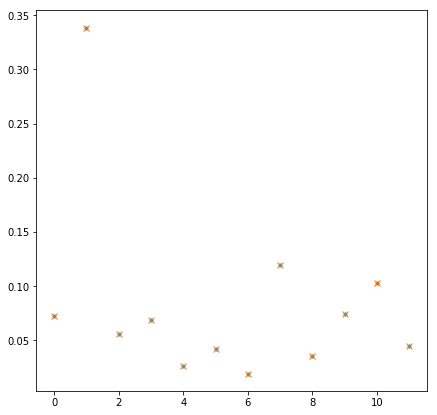

In [22]:
fig, axs = plt.subplots(1, 1, figsize=(7,7))
axs.plot(p, '.')
axs.plot(p1, 'x')

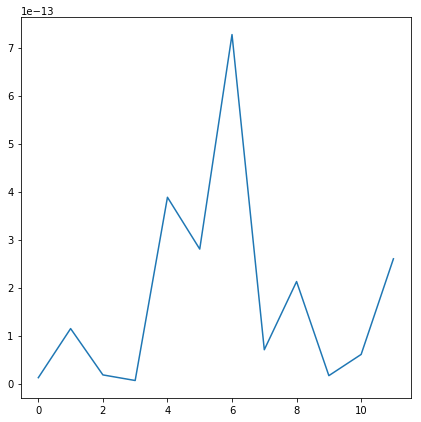

In [23]:
fig, axs = plt.subplots(1, 1, figsize=(7,7))
axs.plot(np.abs(p-p1)/p)

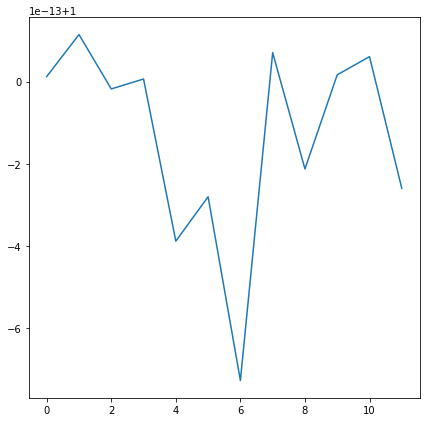

In [24]:
fig, axs = plt.subplots(1, 1, figsize=(7,7))
axs.plot(p1/p)